In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

In [2]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

num_epochs = 100
batch_size = 64
z_size = 20

device_name = 'CPU:0'

tf.random.set_seed(42)
np.random.seed(42)

In [3]:
def build_generator(num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
        model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))

    return model

def build_discriminator(num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))

    return model

In [4]:
gen_model = build_generator(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
)

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        79,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,184 (317.12 KB)

 Trainable params: 81,184 (317.12 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
disc_model = build_discriminator(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,
)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,601 (307.04 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = 2 * image - 1
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=[z_size], minval=-1., maxval=1.
        )
    elif mode == 'normal':
        input_z = tf.random.normal(shape=[z_size])
    
    return input_z, image

mnist_trainset = mnist['train'].map(preprocess).batch(32, drop_remainder=True)

In [7]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size), minval=-1, maxval=1
    )
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size)
    )

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

In [9]:
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)

In [10]:
with tf.device(device_name): # название ГП
    gen_model = build_generator(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = build_discriminator(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

In [11]:
start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
            d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.50 min | Avg Losses >> G/D 2.8624/0.3106 [D-Real: 0.0417 D-Fake: 0.2689]
Epoch 002 | ET 0.99 min | Avg Losses >> G/D 5.1439/0.3286 [D-Real: 0.1077 D-Fake: 0.2208]
Epoch 003 | ET 1.49 min | Avg Losses >> G/D 3.1359/0.7164 [D-Real: 0.3240 D-Fake: 0.3924]
Epoch 004 | ET 1.98 min | Avg Losses >> G/D 2.2487/0.8315 [D-Real: 0.4230 D-Fake: 0.4085]
Epoch 005 | ET 2.47 min | Avg Losses >> G/D 2.0140/0.8527 [D-Real: 0.4521 D-Fake: 0.4006]
Epoch 006 | ET 2.97 min | Avg Losses >> G/D 2.0220/0.8166 [D-Real: 0.4538 D-Fake: 0.3628]
Epoch 007 | ET 3.46 min | Avg Losses >> G/D 1.8370/0.8768 [D-Real: 0.4806 D-Fake: 0.3962]
Epoch 008 | ET 3.94 min | Avg Losses >> G/D 1.4164/1.0486 [D-Real: 0.5660 D-Fake: 0.4825]
Epoch 009 | ET 4.43 min | Avg Losses >> G/D 1.4688/1.0121 [D-Real: 0.5477 D-Fake: 0.4645]
Epoch 010 | ET 4.91 min | Avg Losses >> G/D 1.3579/1.0644 [D-Real: 0.5722 D-Fake: 0.4923]
Epoch 011 | ET 5.40 min | Avg Losses >> G/D 1.2755/1.1106 [D-Real: 0.5892 D-Fake: 0.5214]
Epoch 012 

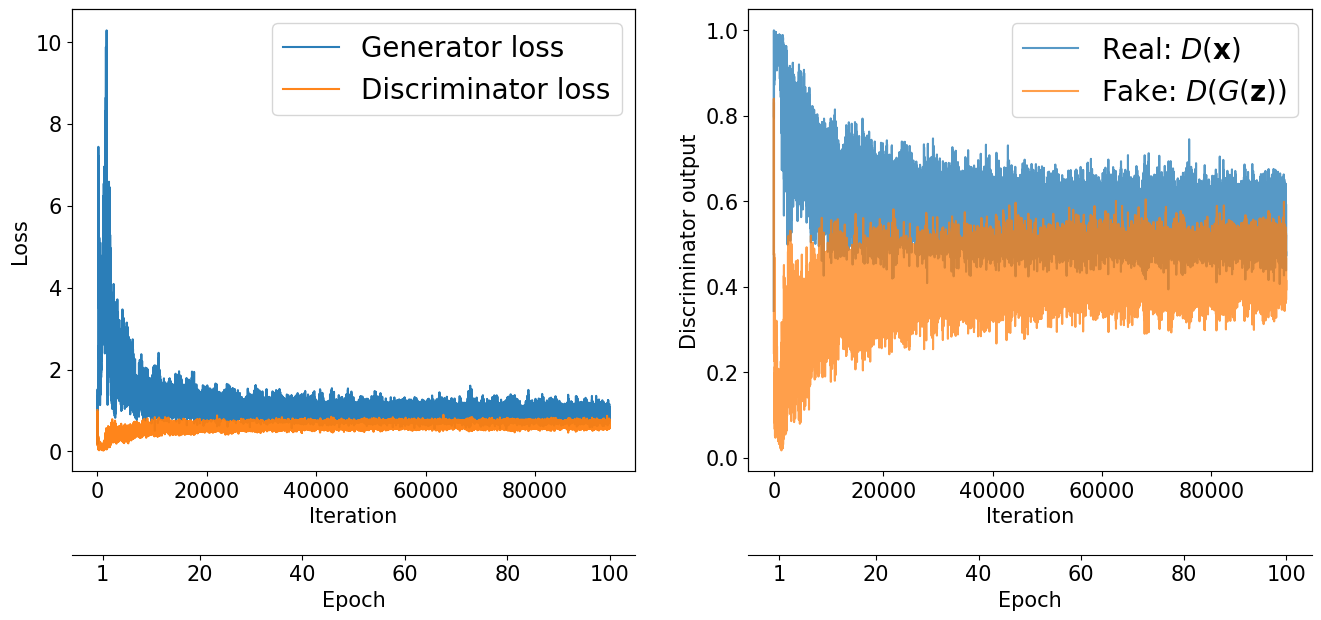

In [12]:
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

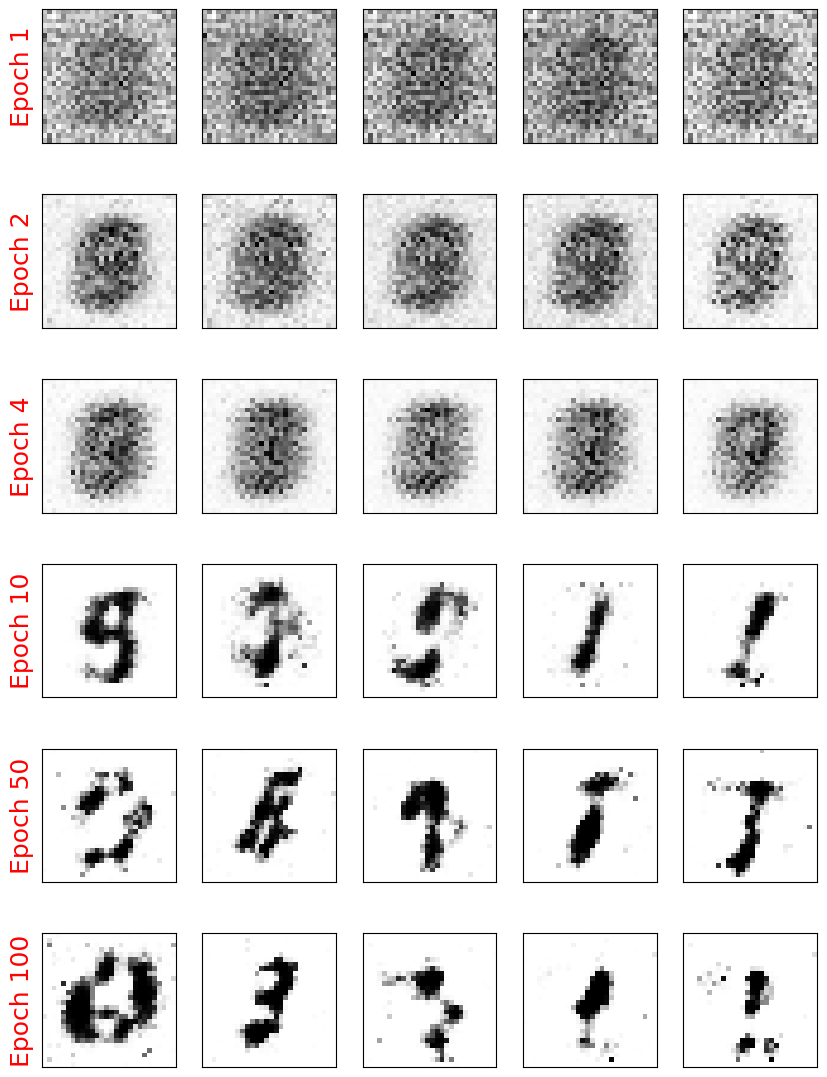

In [13]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()